In [1]:
import ocean_model_skill_assessor as omsa
from IPython.display import Code, Image

# CLI demo of `ocean-model-skill-assessor` with known data files

This demo runs command line interface (CLI) commands only, which is accomplished in a Jupyter notebook by prefacing commands with `!`. To transfer these commands to a terminal window, remove the `!` but otherwise keep commands the same.

More detailed docs about running with the CLI are {doc}`available <cli>`.

There are three steps to follow for a set of model-data validation, which is for one variable:
1. Make a catalog for your model output.
2. Make a catalog for your data.
3. Run the comparison.

These steps will save files into a user application directory cache, along with a log. A project directory can be checked on the command line with `omsa proj_path --project_name PROJECT_NAME`.

## Make model catalog

Set up a catalog file for your model output. The user can input necessary keyword arguments – through `kwargs_open` – so that `xarray` will be able to read in the model output. Generally it is good to use `skip_entry_metadata` when using the `make_catalog` command for model output since we are using only one model and the entry metadata is aimed at being able to compare datasets.

In the following command, 
* `make_catalog` is the function being run from OMSA
* `demo_local` is the name of the project which will be used as the subdirectory name
* `local` is the type of catalog to choose when making a catalog for the model output regardless of where the model output is stored
* "model" is the catalog name which will be used for the file name and in the catalog itself
* Specific `kwargs` to be input to the catalog command are
  * `filenames` which is a string describing where the model output can be found. If the model output is available through a sequence of filenames instead of a single server address, represent them with a single `glob`-style statement, for example, "/filepath/filenameprefix_*.nc".
  * `skip_entry_metadata` use this when running `make_catalog` for model output
* `kwargs_open` all keywords required for `xr.open_dataset` or `xr.open_mfdataset` to successfully read your model output.

In [2]:
!omsa make_catalog --project_name demo_local --catalog_type local --catalog_name model --kwargs filenames="https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-agg/Aggregated_CIOFS_Fields_Forecast_best.ncd" skip_entry_metadata=True  --kwargs_open drop_variables=ocean_time 

[2023-02-07 10:47:59,709] {/Users/kthyng/projects/ocean-model-skill-assessor/ocean_model_skill_assessor/main.py:378} INFO - Catalog saved to /Users/kthyng/Library/Caches/ocean-model-skill-assessor/demo_local/model.yaml with 1 entries.


## Make data catalog 

Set up a catalog of the datasets with which you want to compare your model output. In this example, we use only known data file locations to create our catalog.

In this step, we use the same `project_name` as in the previous step so as to put the resulting catalog file in the same subdirectory, we create a catalog of type "local" since we have known data locations, we call this catalog file "local", input the filenames as a list in quotes (this specific syntax is necessary for inputting a list in through the command line interface), and we input any keyword arguments necessary for reading the datasets.

In the following command:
* `make_catalog` is the function being run from OMSA
* `demo_local` is the name of the project which will be used as the subdirectory name
* `local` is the type of catalog to choose when making a catalog for the known data files
* "local" is the catalog name which will be used for the file name and in the catalog itself
* Specific `kwargs` to be input to the catalog command are
  * `filenames` which is a string or a list of strings pointing to where the data files can be found. If you are using a list, the syntax for the command line interface is `filenames="[file1,file2]"`.
* `kwargs_open` all keywords required for `xr.open_dataset` or `xr.open_mfdataset` or `pandas.open_csv`, or whatever method will ultimately be used to successfully read your model output. These must be applicable to all datasets represted by `filenames`. If they are not, run this command multiple times, one for each set of filenames and `kwargs_open` that match.

In [3]:
!omsa make_catalog --project_name demo_local --catalog_type local --catalog_name local --kwargs filenames="[https://erddap.sensors.axds.co/erddap/tabledap/noaa_nos_co_ops_9455500.csvp?time%2Clatitude%2Clongitude%2Cz%2Csea_water_temperature&time%3E=2022-01-01T00%3A00%3A00Z&time%3C=2022-01-06T00%3A00%3A00Z,https://erddap.sensors.axds.co/erddap/tabledap/aoos_204.csvp?time%2Clatitude%2Clongitude%2Cz%2Csea_water_temperature&time%3E=2022-01-01T00%3A00%3A00Z&time%3C=2022-01-06T00%3A00%3A00Z]" --kwargs_open blocksize=None

[2023-02-07 10:48:07,589] {/Users/kthyng/projects/ocean-model-skill-assessor/ocean_model_skill_assessor/main.py:184} WARNING - Dataset noaa_nos_co_ops_9455500 had a timezone UTC which is being removed. Make sure the timezone matches the model output.
[2023-02-07 10:48:10,140] {/Users/kthyng/projects/ocean-model-skill-assessor/ocean_model_skill_assessor/main.py:184} WARNING - Dataset aoos_204 had a timezone UTC which is being removed. Make sure the timezone matches the model output.
[2023-02-07 10:48:10,148] {/Users/kthyng/projects/ocean-model-skill-assessor/ocean_model_skill_assessor/main.py:378} INFO - Catalog saved to /Users/kthyng/Library/Caches/ocean-model-skill-assessor/demo_local/local.yaml with 2 entries.


## Run comparison

Now that the model output and dataset catalogs are prepared, we can run the comparison of the two.

In this step, we use the same `project_name` as the other steps so as to keep all files in the same subdirectory. We input the data catalog name under `catalog_names` and the model catalog name under `model_name`. 

At this point we need to select a single variable to compare between the model and datasets, and this requires a little extra input. Because we don't know anything about the format of any given input data file, variables will be interpreted with some flexibility in the form of a set of regular expressions. In the present case, we will compare the water temperature between the model and the datasets (the model output and datasets selected for our catalogs should contain the variable we want to compare). Several sets of regular expressions, called "vocabularies", are available with the package to be used for this purpose, and in this case we will use one called "general" which should match many commonly-used variable names. "general" is selected under `vocab_names`, and the particular key from the general vocabulary that we are comparing is selected with `key`.

See the vocabulary here.

In [4]:
import cf_pandas as cfp

vocab = cfp.Vocab(omsa.VOCAB_PATH("general"))
vocab

{'temp': {'name': '(?i)^(?!.*(air|qc|status|atmospheric|bottom|dew)).*(temp|sst).*'}, 'salt': {'name': '(?i)^(?!.*(soil|qc|status|bottom)).*(sal|sss).*'}, 'ssh': {'name': '(?i)^(?!.*(qc|status)).*(sea_surface_height|surface_elevation).*'}, 'u': {'name': 'u$|(?i)(?=.*east)(?=.*vel)'}, 'v': {'name': 'v$|(?i)(?=.*north)(?=.*vel)'}, 'w': {'name': 'w$|(?i)(?=.*up)(?=.*vel)'}, 'water_dir': {'name': '(?i)^(?!.*(qc|status|air|wind))(?=.*dir)(?=.*water)'}, 'water_speed': {'name': '(?i)^(?!.*(qc|status|air|wind))(?=.*speed)(?=.*water)'}, 'wind_dir': {'name': '(?i)^(?!.*(qc|status|water))(?=.*dir)(?=.*wind)'}, 'wind_speed': {'name': '(?i)^(?!.*(qc|status|water))(?=.*speed)(?=.*wind)'}, 'sea_ice_u': {'name': '(?i)^(?!.*(qc|status))(?=.*sea)(?=.*ice)(?=.*u)|(?i)^(?!.*(qc|status))(?=.*sea)(?=.*ice)(?=.*x)(?=.*vel)|(?i)^(?!.*(qc|status))(?=.*sea)(?=.*ice)(?=.*east)(?=.*vel)'}, 'sea_ice_v': {'name': '(?i)^(?!.*(qc|status))(?=.*sea)(?=.*ice)(?=.*v)|(?i)^(?!.*(qc|status))(?=.*sea)(?=.*ice)(?=.*y)(?=.*ve

In the following command:
* `run` is the function being run from OMSA
* `demo_local` is the name of the project which will be used as the subdirectory name
* `catalog_names` are the names of any catalogs with datasets to include in the comparison. In this case we have just one called "local"
* `model_name` is the name of the model catalog we previously created
* `vocab_names` are the names of the vocabularies to use for interpreting which variable to compare from the model output and datasets. If multiple are input, they are combined together. The variable nicknames need to match in the vocabularies to be interpreted together.
* `key` is the nickname or alias of the variable as given in the input vocabulary

In [5]:
!omsa run --project_name demo_local --catalog_names local --model_name model --vocab_names general --key temp

[2023-02-07 10:48:13,769] {/Users/kthyng/projects/ocean-model-skill-assessor/ocean_model_skill_assessor/main.py:451} INFO - Note that there are 2 datasets to use. This might take awhile.
[2023-02-07 10:48:25,626] {/Users/kthyng/miniconda3/envs/omsa/lib/python3.10/warnings.py:109} WARNING - /Users/kthyng/miniconda3/envs/omsa/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'u' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

[2023-02-07 10:48:25,626] {/Users/kthyng/miniconda3/envs/omsa/lib/python3.10/warnings.py:109} WARNING - /Users/kthyng/miniconda3/envs/omsa/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'v' has multiple fill values {0.0, 1e+37}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

[2023-02-07 10:48:25,627] {/Users/kthyng/miniconda3/envs/omsa/lib/python3.10/warnings.py:109} WARNING - /Users/kthyng/miniconda3/envs/omsa/lib/py

## Look at results

Now we can look at the results from our comparison! You can find the location of the resultant files printed at the end of the `run` command output above. Or you can find the path to the project directory while in Python with:

In [6]:
omsa.PROJ_DIR("demo_local")

PosixPath('/Users/kthyng/Library/Caches/ocean-model-skill-assessor/demo_local')

Or you can use a command:

In [7]:
!omsa proj_path --project_name demo_local

/Users/kthyng/Library/Caches/ocean-model-skill-assessor/demo_local


Here we know the names of the files so show them inline.

First we see a map of the area around Cook Inlet in Alaska, along with a red line outlining the approximate domain of the numerical model, and 2 black dots indicating 2 data locations, each with a numeric marker for matching to the model-data time series comparison.

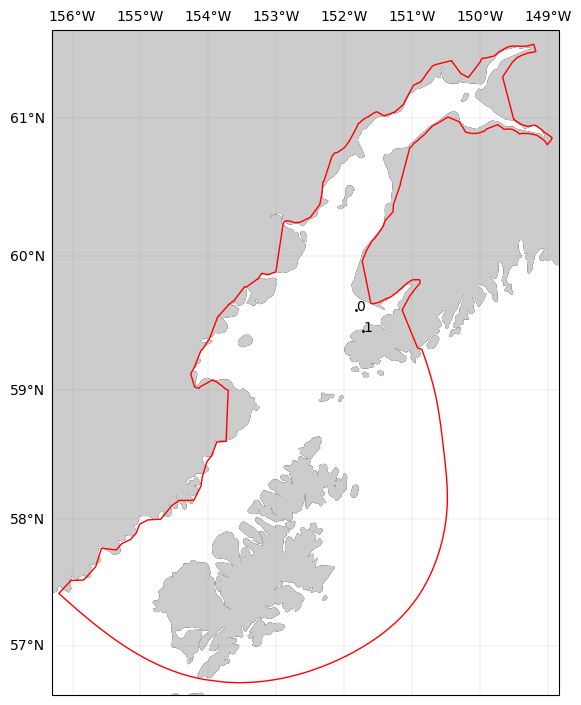

In [8]:
Image(omsa.PROJ_DIR("demo_local") / "map.png")

Here we see a time series comparison at marker "1" from the map, station "noaa_nos_co_ops_9455500". It shows in black the temperature values from the data and in red the comparable values from the model. The comparison time range is January 1, 2022, through January 5, 2022. The lines are reasonably similar, as captured by the statistical values in the title.

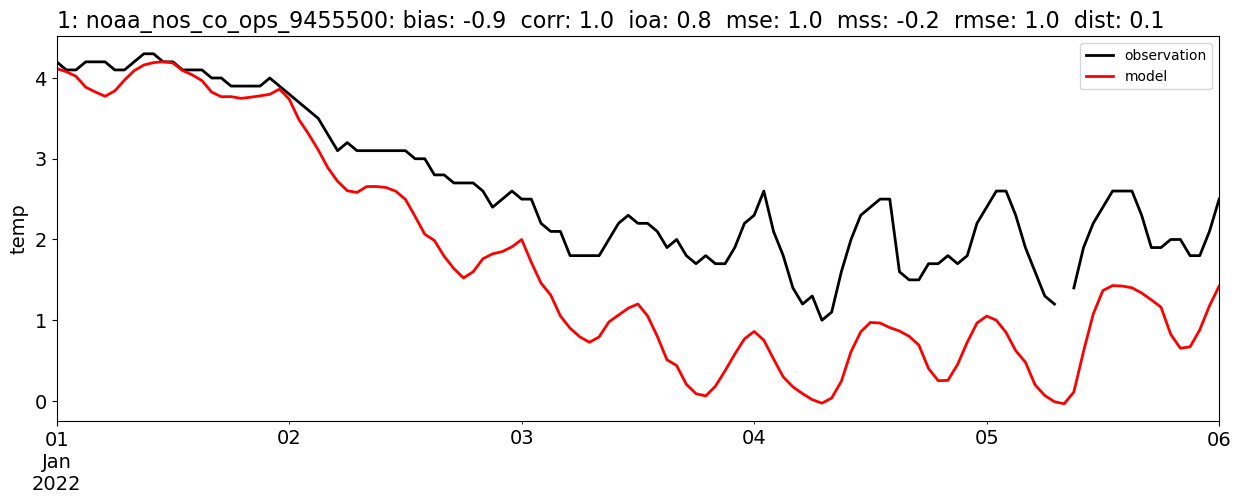

In [9]:
Image(omsa.PROJ_DIR("demo_local") / "noaa_nos_co_ops_9455500_temp.png")

In [10]:
import yaml
with open(omsa.PROJ_DIR("demo_local") / "stats_noaa_nos_co_ops_9455500_temp.yaml", "r") as stream:
    stats = yaml.safe_load(stream)
stats


{'bias': {'long_name': 'Bias or MSD',
  'name': 'Bias',
  'value': -0.8845030895465363},
 'corr': {'long_name': 'Pearson product-moment correlation coefficient',
  'name': 'Correlation Coefficient',
  'value': 0.9749357696125563},
 'descriptive': {'long_name': 'Max, Min, Mean, Standard Deviation',
  'name': 'Descriptive Statistics',
  'value': [4.201254844665527,
   -0.03469964489340782,
   1.705991268157959,
   1.3660595417022705]},
 'dist': {'long_name': 'Distance in km from data location to selected model location',
  'name': 'Distance',
  'value': 0.09251444479051014},
 'ioa': {'long_name': 'Index of Agreement (Willmott 1981)',
  'name': 'Index of Agreement',
  'value': 0.8251364574472198},
 'mse': {'long_name': 'Mean Squared Error (MSE)',
  'name': 'Mean Squared Error',
  'value': 1.0417023196727062},
 'mss': {'long_name': 'Murphy Skill Score (Murphy 1988)',
  'name': 'Murphy Skill Score',
  'value': -0.2333068101929292},
 'rmse': {'long_name': 'Root Mean Square Error (RMSE)',
  '

Here we see a time series comparison at marker "0" from the map, station "aoos_204". It shows in black the temperature values from the data and in red the comparable values from the model. The comparison time range is January 1, 2022, through January 5, 2022. The data values are mostly missing, but the model output is present.

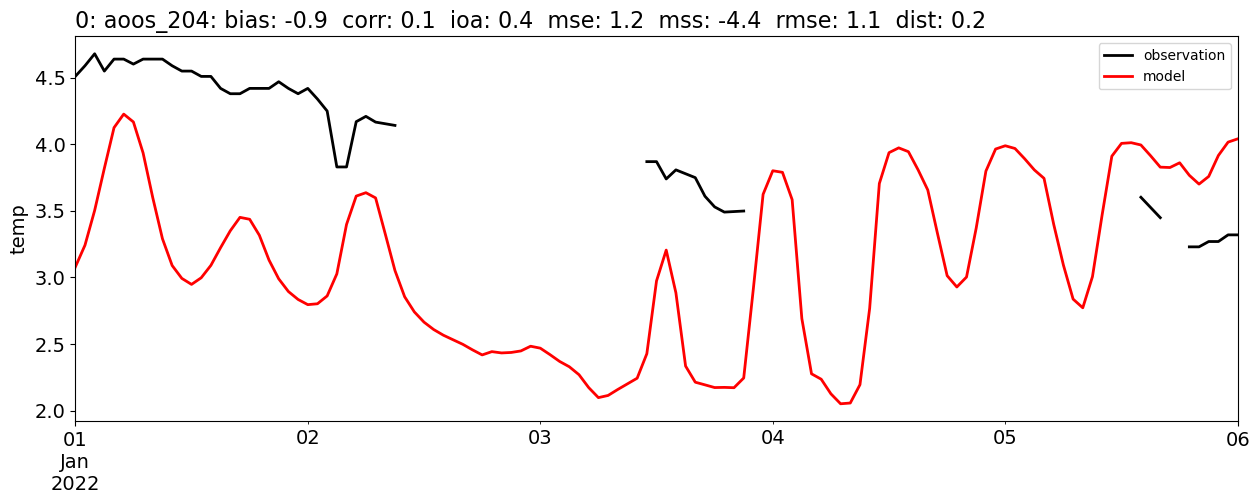

In [11]:
Image(omsa.PROJ_DIR("demo_local") / "aoos_204_temp.png")

In [12]:
with open(omsa.PROJ_DIR("demo_local") / "stats_aoos_204_temp.yaml", "r") as stream:
    stats = yaml.safe_load(stream)
stats

{'bias': {'long_name': 'Bias or MSD',
  'name': 'Bias',
  'value': -0.8507218386346141},
 'corr': {'long_name': 'Pearson product-moment correlation coefficient',
  'name': 'Correlation Coefficient',
  'value': 0.09347213160100319},
 'descriptive': {'long_name': 'Max, Min, Mean, Standard Deviation',
  'name': 'Descriptive Statistics',
  'value': [4.227032661437988,
   2.051501989364624,
   3.102297782897949,
   0.6421294808387756]},
 'dist': {'long_name': 'Distance in km from data location to selected model location',
  'name': 'Distance',
  'value': 0.24902632757445903},
 'ioa': {'long_name': 'Index of Agreement (Willmott 1981)',
  'name': 'Index of Agreement',
  'value': 0.3713415271280024},
 'mse': {'long_name': 'Mean Squared Error (MSE)',
  'name': 'Mean Squared Error',
  'value': 1.223021304783012},
 'mss': {'long_name': 'Murphy Skill Score (Murphy 1988)',
  'name': 'Murphy Skill Score',
  'value': -4.418748997077633},
 'rmse': {'long_name': 'Root Mean Square Error (RMSE)',
  'name